# Compute Rt for Haredim cities (Bnei-Brak, Elad, Modiin-Ilit, Beitar-Ilit)

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-wriwzt29 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
dfcit = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False, cities=True)
bb = ['6100', '3780', '3797', '1309', '1137']
model_bb = dfcit.loc[bb].groupby('date').sum()
gmbb = GenerativeModel(bb, model_bb, buffer_days = 10, delay=2, sigma=0.07)
gmbb.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1141 seconds.


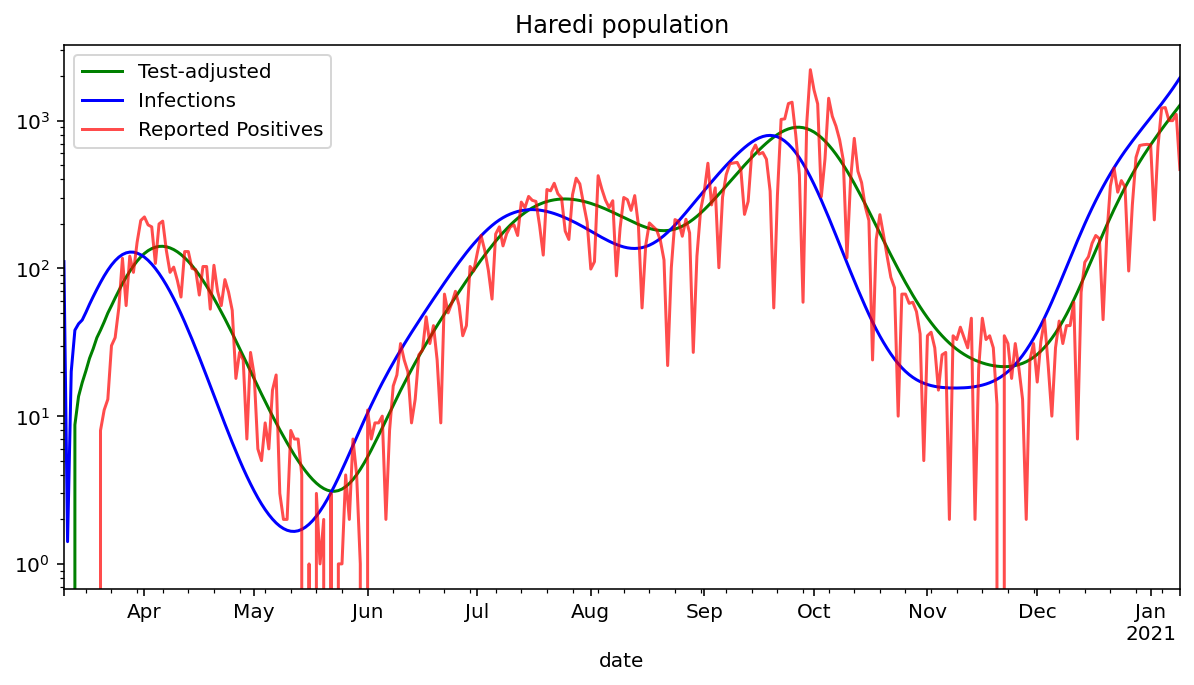

In [3]:
resultbb = summarize_inference_data(gmbb.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Haredi population")
resultbb.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultbb.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultbb.infections.plot(c="b", label="Infections")
gmbb.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmbb.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

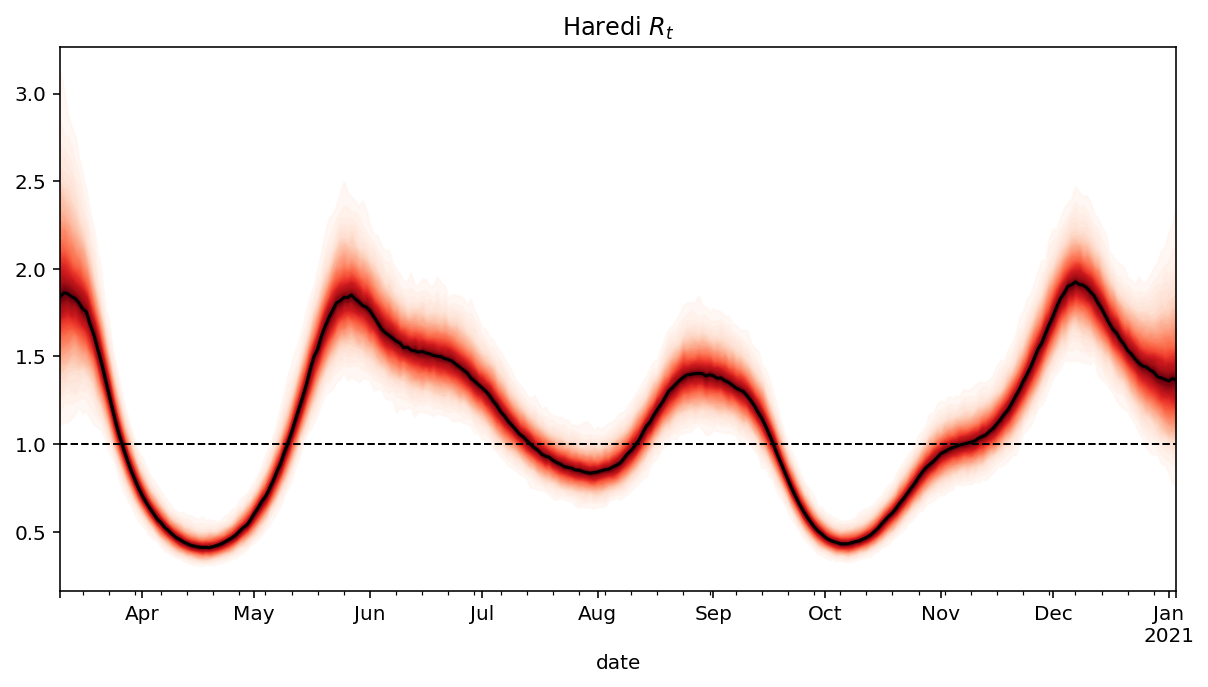

In [4]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Haredi $R_t$")
samples = gmbb.trace['r_t']
x=resultbb.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultbb["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [5]:
resultbb.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-11-11,1.038527,1.032373,0.860059,1.164005,15.555067,26.197536,34.0,34.0,500000
2020-11-12,1.050644,1.042197,0.881898,1.187183,15.613267,25.331378,29.0,29.0,500000
2020-11-13,1.063174,1.052946,0.917735,1.212031,15.705094,24.583865,46.0,46.0,500000
2020-11-14,1.078852,1.072799,0.932866,1.226194,15.836644,23.940534,2.0,2.0,500000
2020-11-15,1.096768,1.090516,0.939466,1.241205,16.007267,23.389378,21.0,21.0,500000
2020-11-16,1.122516,1.116865,0.949167,1.255288,16.221808,22.921383,46.0,46.0,500000
2020-11-17,1.145783,1.142436,0.993047,1.300984,16.489940,22.530134,33.0,33.0,500000
2020-11-18,1.174903,1.172167,1.021370,1.334812,16.828622,22.210941,35.0,35.0,500000
2020-11-19,1.202633,1.196724,1.023928,1.360908,17.250460,21.960675,29.0,29.0,500000


# General population

In [6]:
gn = ['5000', '8400', '8300', '1139', '2800', '9000', '2600', '6500', '6600', '6200', '9500']
model_gn = dfcit.loc[gn].groupby('date').sum()
gmgn = GenerativeModel(gn, model_gn, buffer_days = 10, delay=2, sigma=0.07)
gmgn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1334 seconds.


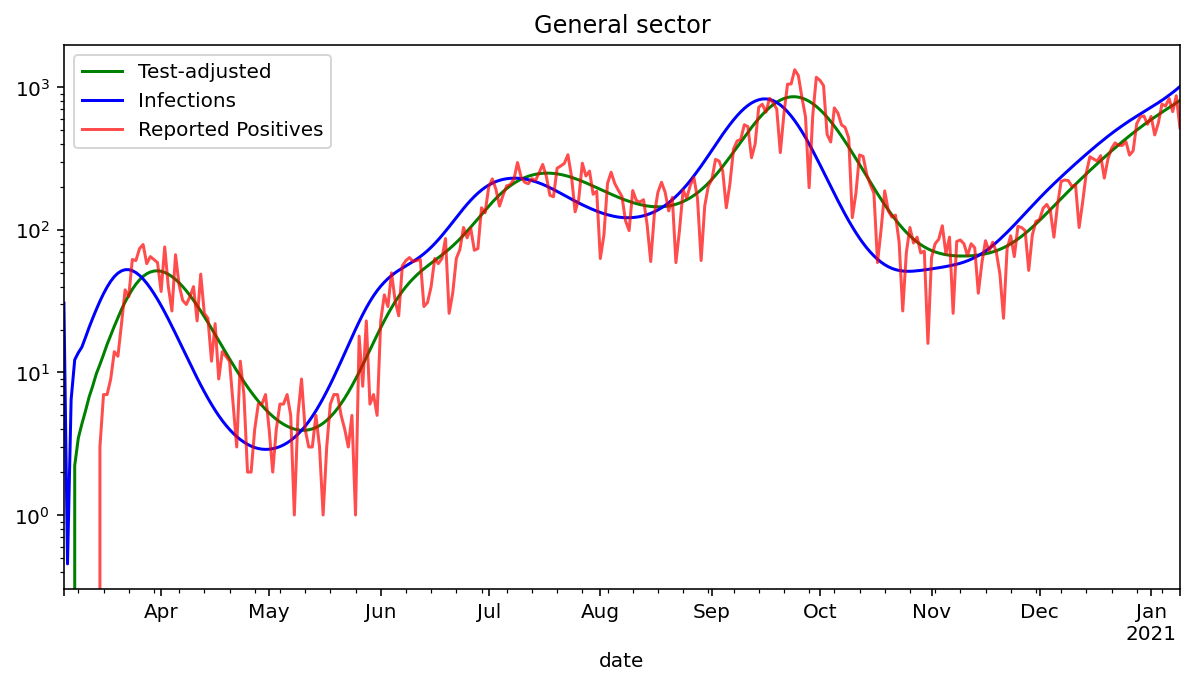

In [7]:
resultgn = summarize_inference_data(gmgn.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("General sector")
resultgn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultgn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultgn.infections.plot(c="b", label="Infections")
gmgn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmgn.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

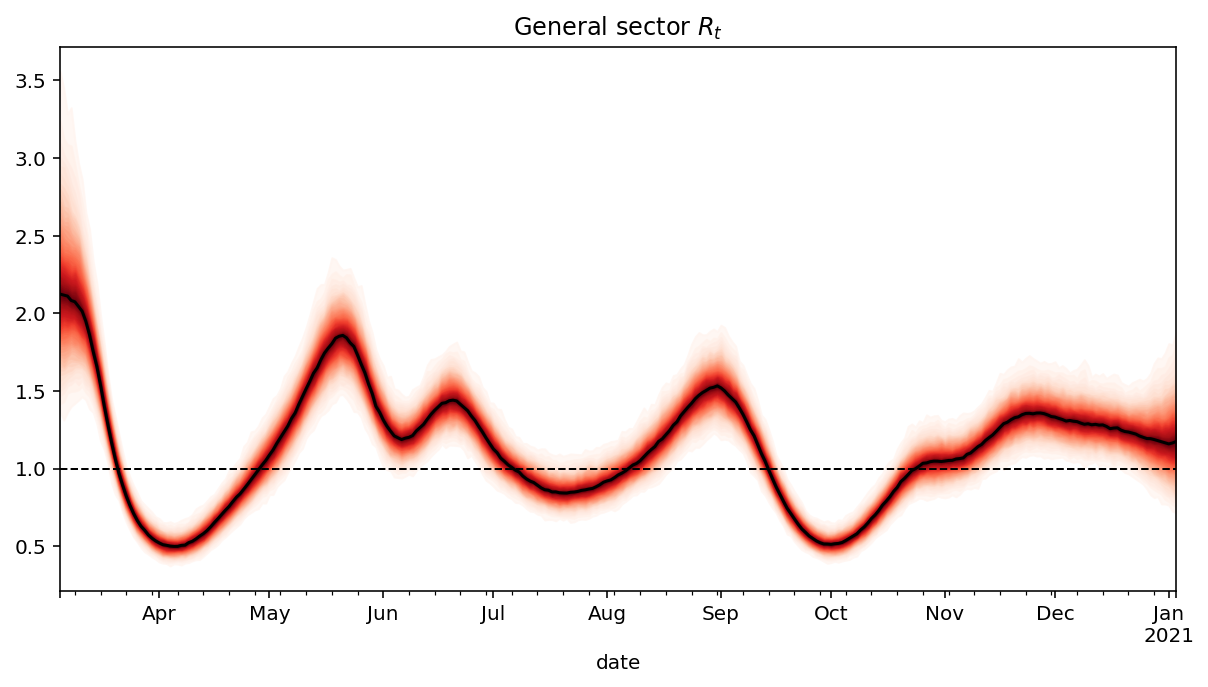

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"General sector $R_t$")
samples = gmgn.trace['r_t']
x=resultgn.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultgn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [9]:
resultgn.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-11-11,1.157575,1.154822,0.993136,1.280139,60.768776,65.679797,66.0,66.0,1100000
2020-11-12,1.182485,1.179307,1.045708,1.341479,62.265425,65.880562,80.0,80.0,1100000
2020-11-13,1.205755,1.198014,1.031609,1.339789,64.001114,66.200259,75.0,75.0,1100000
2020-11-14,1.224333,1.215643,1.072386,1.378252,66.036115,66.650332,36.0,36.0,1100000
2020-11-15,1.247988,1.239478,1.078987,1.397466,68.413411,67.244666,59.0,59.0,1100000
2020-11-16,1.270539,1.264652,1.116775,1.438554,71.126162,67.999935,84.0,84.0,1100000
2020-11-17,1.291207,1.288575,1.134396,1.446750,74.206840,68.937778,71.0,71.0,1100000
2020-11-18,1.303844,1.297888,1.140529,1.460154,77.715413,70.084421,82.0,82.0,1100000
2020-11-19,1.323260,1.314055,1.150105,1.493146,81.678621,71.466395,70.0,70.0,1100000


# Arab cities

In [10]:
ar = ['472', '2710', '6000', '2730', '2720', '8900', '509', '634', '7300', '7500', '531', '637', '638', '543', '8800']
model_ar = dfcit.loc[ar].groupby('date').sum()
gmar = GenerativeModel(ar, model_ar, buffer_days = 10, delay=2, sigma=0.07)
gmar.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1184 seconds.


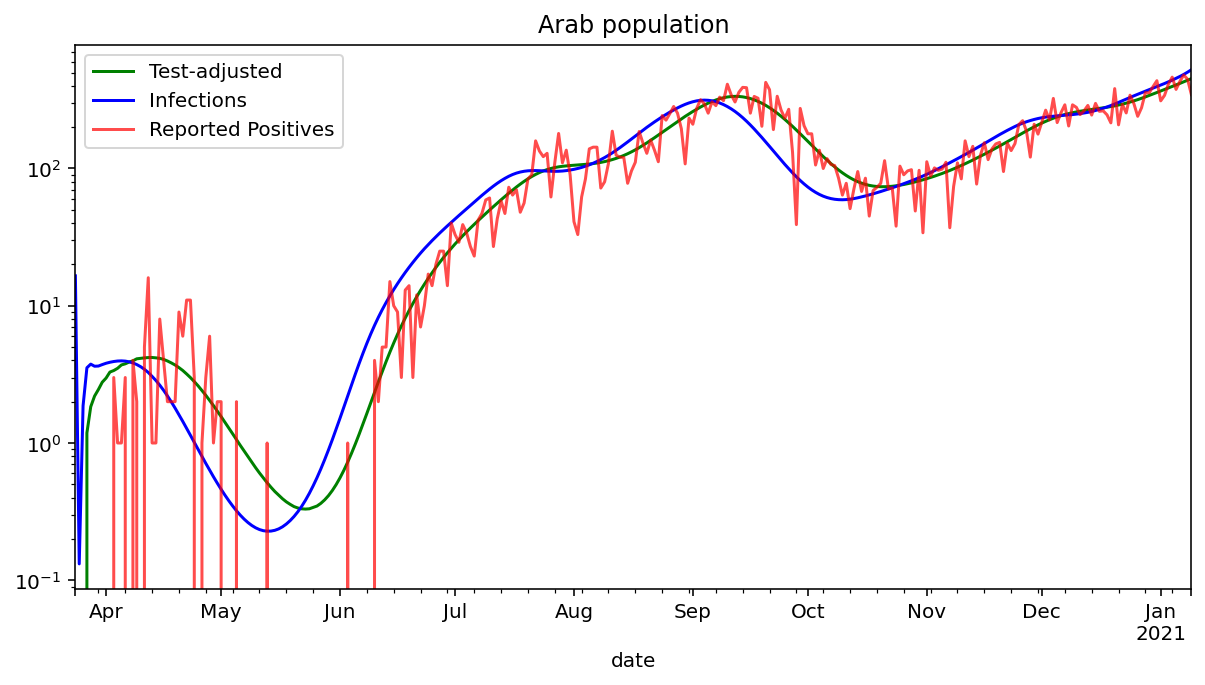

In [11]:
resultar = summarize_inference_data(gmar.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Arab population")
resultar.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultar.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultar.infections.plot(c="b", label="Infections")
gmar.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

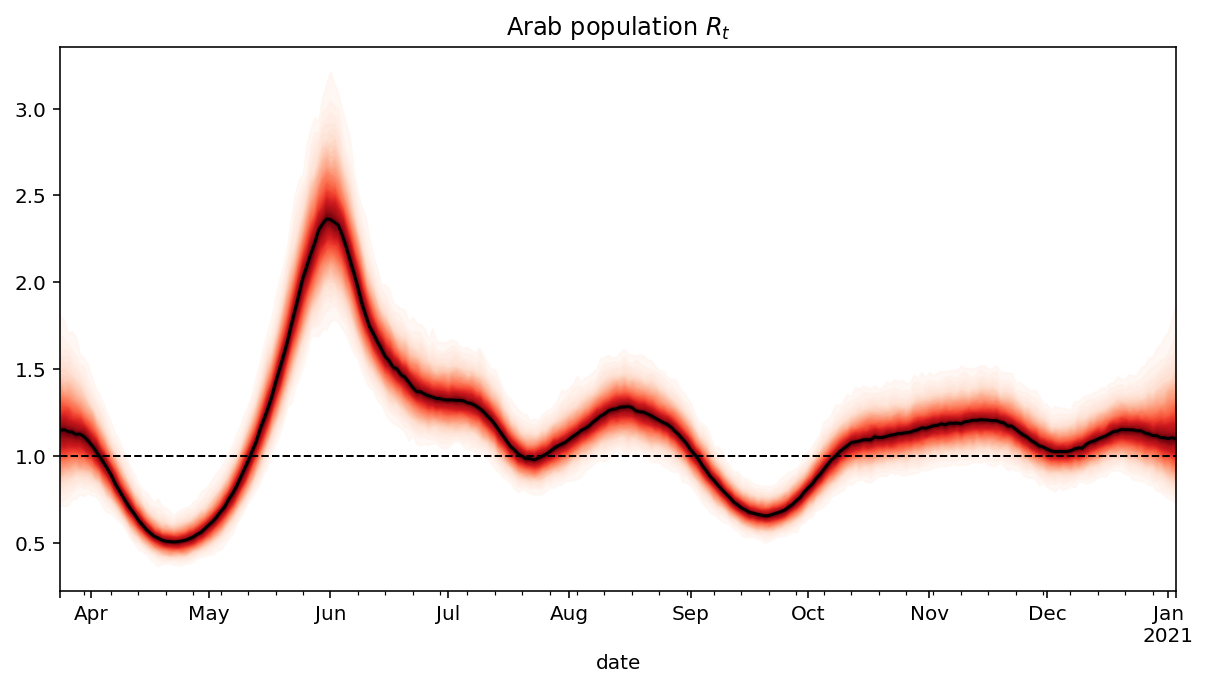

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Arab population $R_t$")
samples = gmar.trace['r_t']
x=resultar.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultar["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [13]:
resultar.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-11-11,1.204440,1.198946,1.055251,1.351201,126.421020,108.276550,159.0,159.0,1500000
2020-11-12,1.208483,1.205035,1.027357,1.335870,131.013804,111.628673,122.0,122.0,1500000
2020-11-13,1.211929,1.204836,1.047066,1.351762,135.860341,115.170696,145.0,145.0,1500000
2020-11-14,1.213797,1.208272,1.052305,1.367814,140.964494,118.905104,77.0,77.0,1500000
2020-11-15,1.214224,1.206466,1.047138,1.360673,146.348767,122.837639,125.0,125.0,1500000
2020-11-16,1.211578,1.205806,1.056159,1.358580,152.001158,126.977340,154.0,154.0,1500000
2020-11-17,1.209218,1.202697,1.030297,1.339541,157.893324,131.334489,116.0,116.0,1500000
2020-11-18,1.208410,1.203037,1.066093,1.379006,163.979358,135.921061,139.0,139.0,1500000
2020-11-19,1.197224,1.194501,1.030941,1.320944,170.227027,140.748745,151.0,151.0,1500000


In [14]:
jr = ['3000']
model_jr = dfcit.loc[jr].groupby('date').sum()
gmjr = GenerativeModel(jr, model_jr, buffer_days = 10, delay=2)
gmjr.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1127 seconds.


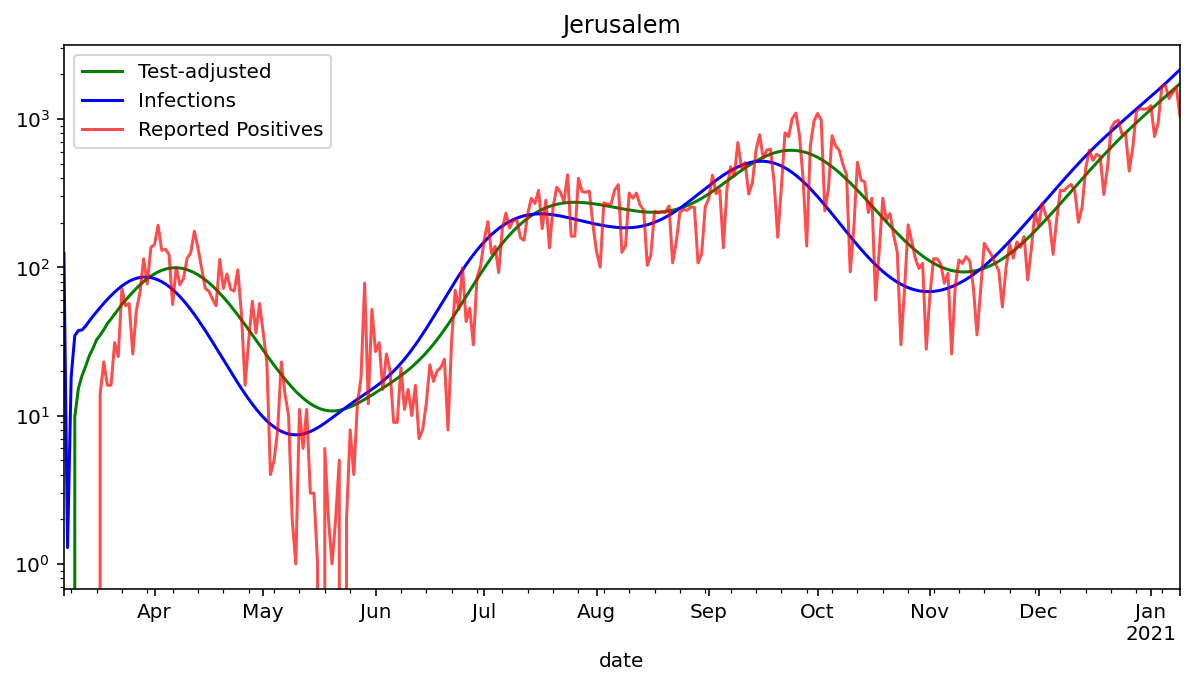

In [15]:
resultjr = summarize_inference_data(gmjr.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Jerusalem")
resultjr.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultjr.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultjr.infections.plot(c="b", label="Infections")
gmjr.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
d = gmjr.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

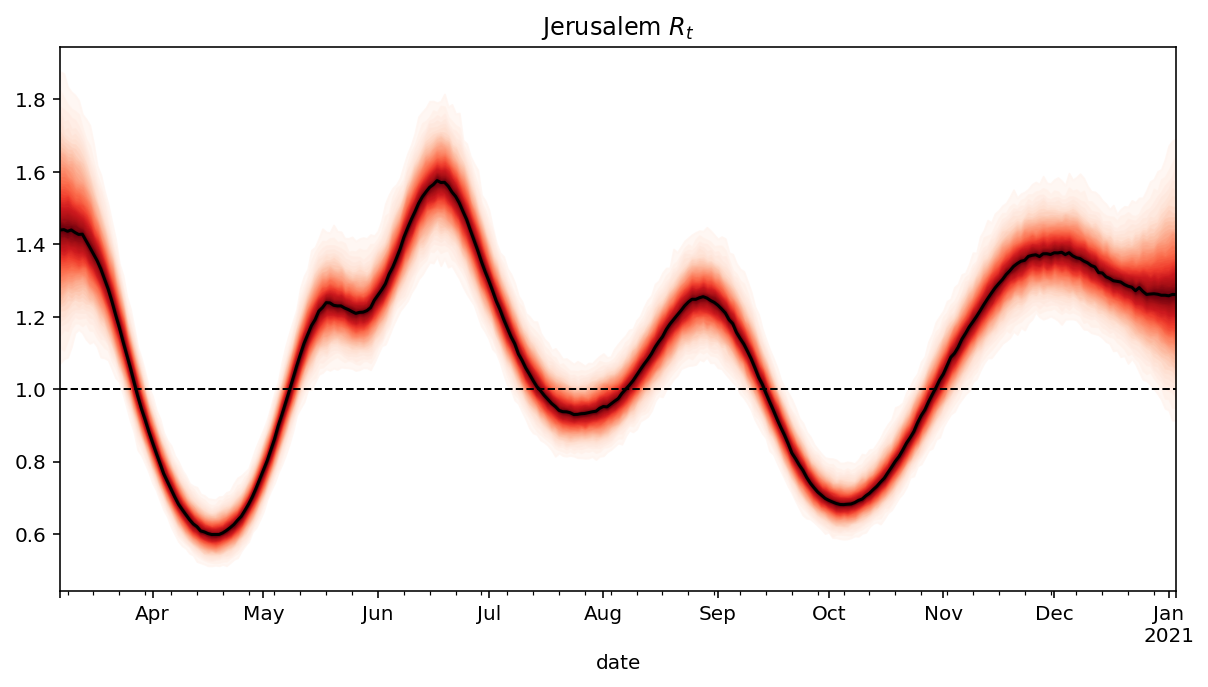

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Jerusalem $R_t$")
samples = gmjr.trace['r_t']
x=resultjr.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultjr["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [17]:
resultjr.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-11-11,1.221673,1.216859,1.106712,1.305630,82.894793,92.976569,118.0,118.0,100000
2020-11-12,1.238705,1.233866,1.127726,1.329054,85.930845,93.360271,110.0,110.0,100000
2020-11-13,1.253461,1.249687,1.147185,1.343918,89.330869,94.097856,73.0,73.0,100000
2020-11-14,1.266735,1.264708,1.163572,1.362645,93.128459,95.191381,35.0,35.0,100000
2020-11-15,1.281715,1.279171,1.174743,1.382503,97.341873,96.645944,70.0,70.0,100000
2020-11-16,1.294698,1.291328,1.188132,1.395796,101.981057,98.470660,145.0,145.0,100000
2020-11-17,1.309437,1.302512,1.199435,1.411895,107.089357,100.679229,132.0,132.0,100000
2020-11-18,1.321326,1.316207,1.215696,1.420549,112.710914,103.288140,121.0,121.0,100000
2020-11-19,1.330283,1.326761,1.234284,1.437922,118.896953,106.315168,106.0,106.0,100000


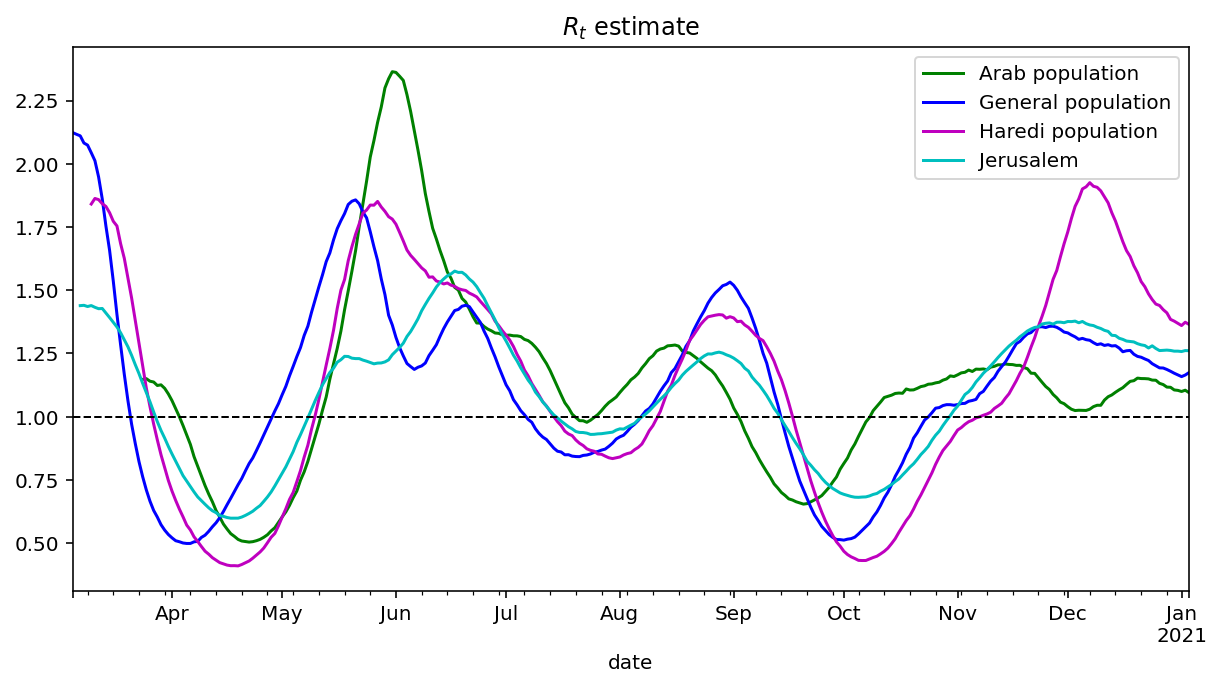

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"$R_t$ estimate")
resultar["median"].plot(c="g", ls='-', label="Arab population")
resultgn["median"].plot(c="b", ls='-', label="General population")
resultbb["median"].plot(c="m", ls='-', label="Haredi population")
resultjr["median"].plot(c="c", ls='-', label="Jerusalem")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
ax.legend()

In [19]:
resultar.to_csv("results_arab_cities_out.csv")
resultbb.to_csv("results_haredi_cities_out.csv")
resultgn.to_csv("results_general_cities_out.csv")
resultjr.to_csv("results_jerusalem_out.csv")

{'3604', '3650', '3563', '3726', '3618', '3725'}


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1125 seconds.


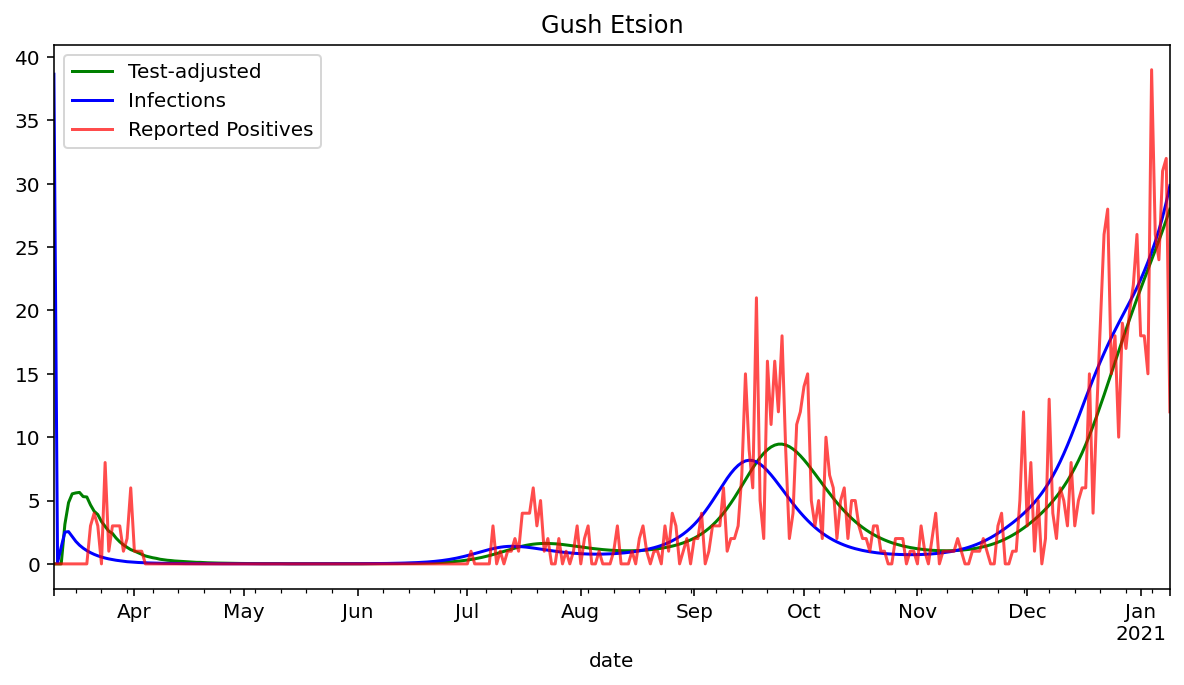

In [20]:
gush = ["3604", "3618", "3650", "3794", "3603", "3488", "3561", "3653", "3725", "3726", "1982", "1981", "3781", "3602", "3563"]
gush = set(gush) & set(list(dfcit.index.unique(0)))
print(gush)
model_gs = dfcit.loc[gush].groupby('date').sum()
gmgs = GenerativeModel(gush, model_gs, buffer_days = 10, delay=2, sigma=0.07)
gmgs.sample()

resultgs = summarize_inference_data(gmgs.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Gush Etsion")
resultgs.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultbb.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultgs.infections.plot(c="b", label="Infections")
gmgs.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmbb.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
#plt.yscale("log")
ax.legend();

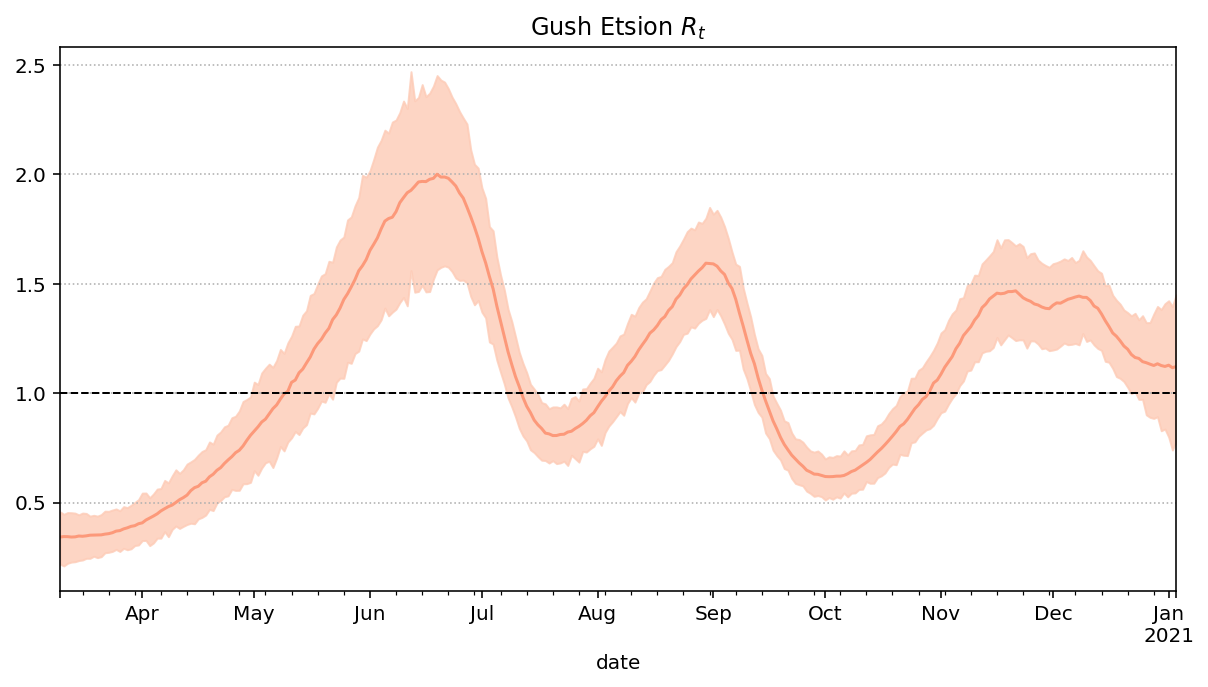

In [21]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Gush Etsion $R_t$")
samples = gmgs.trace['r_t']
x=resultgs.index
colmap = plt.get_cmap("Reds")
ax.fill_between(x, resultgs["upper_80"], resultgs["lower_80"], color=colmap(50), alpha=.8)
resultgs["median"].plot(c=colmap(90), ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')
plt.grid(which='major', axis='y', ls=':')
